In [40]:
import json
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
from PIL import Image
import io
from tqdm import tqdm
import os
import multiprocessing as mp

def load_and_resize_image(args):
    image_info, input_dir = args
    try:
        file_name = image_info['file_name']
        image_path = os.path.join(input_dir, file_name)
        
        original_image = Image.open(image_path)
        original_width, original_height = original_image.size
        resized_image = original_image.resize((640, 640))
        resized_image_bytes = io.BytesIO()
        resized_image.save(resized_image_bytes, format='PNG')
        resized_image_bytes = resized_image_bytes.getvalue()
        
        scale_x = 640 / original_width
        scale_y = 640 / original_height
        
        return image_info['id'], file_name, resized_image_bytes, (scale_x, scale_y)
    except Exception as e:
        print(f'Exception occurred for image {file_name}: {str(e)}')
        return None

def process_and_write(queue, coco_annotations, schema, output_dir, max_entries_per_file):
    writer = None
    file_count = 1
    entry_count = 0
    
    annotation_dict = {ann['image_id']: ann for ann in coco_annotations}
    
    while True:
        item = queue.get()
        if item is None:
            break
        
        image_id, file_name, resized_image_bytes, scale = item
        
        if writer is None or entry_count >= max_entries_per_file:
            if writer:
                writer.close()
            output_file = os.path.join(output_dir, f'resized_dataset_train_640_{file_count}.parquet')
            writer = pq.ParquetWriter(output_file, schema)
            file_count += 1
            entry_count = 0
        
        # Get and update annotations
        ann = annotation_dict.get(image_id, [])
        scale_x, scale_y = scale
        updated_annotations = [
            {
                'bbox': [ann['bbox'][i] * (scale_x if i % 2 == 0 else scale_y) for i in range(4)],
                'category_id': ann['category_id']
            }
        ] if ann else []
        
        if updated_annotations:
            # Create a single-row table and write it
            table = pa.Table.from_pydict({
                'image_id': [image_id],
                'file_name': [file_name],
                'image': [resized_image_bytes],
                'annotations': [updated_annotations]
            }, schema=schema)
            writer.write_table(table)
            entry_count += 1
    
    if writer:
        writer.close()

def main():
    # Load the COCO dataset annotations
    with open('annotations_trainval2017/annotations/instances_train2017.json', 'r') as f:
        coco_data = json.load(f)

    # Create Parquet schema
    schema = pa.schema([
        ('image_id', pa.int64()),
        ('file_name', pa.string()),
        ('image', pa.binary()),
        ('annotations', pa.list_(pa.struct([
            ('bbox', pa.list_(pa.float64())),
            ('category_id', pa.int64())
        ])))
    ])

    # Initialize variables
    max_entries_per_file = 7000
    input_dir = './COCO/train2017'
    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)

    # Create a queue for communication between processes
    queue = mp.Queue(maxsize=100)

    # Start the consumer process
    consumer_process = mp.Process(target=process_and_write, 
                                  args=(queue, coco_data['annotations'], schema, output_dir, max_entries_per_file))
    consumer_process.start()

    # Process images using multiple processes
    with mp.Pool(processes=mp.cpu_count() - 1) as pool:
        for result in tqdm(pool.imap_unordered(load_and_resize_image, 
                                               ((image, input_dir) for image in coco_data['images']),
                                               chunksize=10), 
                           total=len(coco_data['images']), 
                           desc="Processing images"):
            if result:
                queue.put(result)

    # Signal the end of processing
    queue.put(None)

    # Wait for the consumer process to finish
    consumer_process.join()

if __name__ == '__main__':
    main()

Processing images: 100%|██████████| 118287/118287 [16:14<00:00, 121.39it/s]


In [1]:
import pandas as pd

In [35]:
df = pd.read_parquet('/home/muhammadfasi/Downloads/FYP/datasets/output/resized_dataset_test_640_1.parquet').reset_index()
df

,index,image_id,file_name,image,annotations
0,0,475779,000000475779.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [0.0, 158.76, 466.87, 481.24], 'cate..."
1,1,301867,000000301867.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [242.45, 464.9333333333333, 29.57, 9..."
2,2,312421,000000312421.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [529.48, 0.0, 110.52, 208.3372365339..."
3,3,185250,000000185250.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [196.1062656641604, 364.9, 16.360902..."
4,4,356427,000000356427.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [389.58, 473.01545667447306, 55.84, ..."
...,...,...,...,...,...
4947,4947,512403,000000512403.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [264.1421550094518, 109.17, 375.8578..."
4948,4948,168974,000000168974.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [162.67946666666666, 41.356800000000..."
4949,4949,552775,000000552775.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [0.0, 0.0, 236.544, 568.0384], 'cate..."
4950,4950,394940,000000394940.jpg,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,"[{'bbox': [0.0, 77.18, 639.6845070422535, 413...."


In [38]:
df.loc[24]['annotations']

array([{'bbox': array([  0.        ,  18.        , 638.49411765, 341.        ]), 'category_id': 1}],
      dtype=object)

(640, 640)


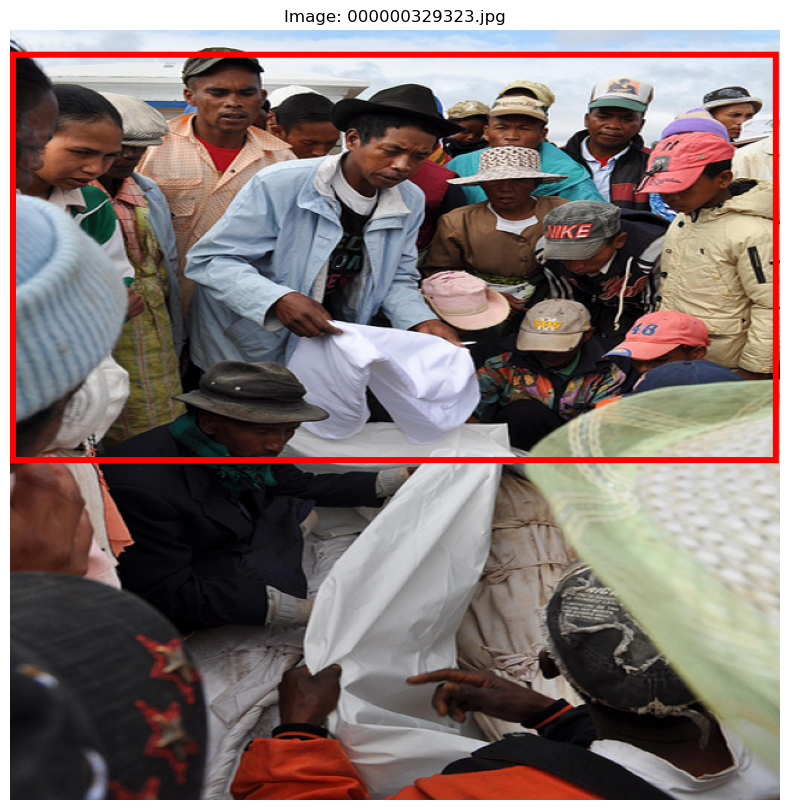

In [39]:
import io
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def display_image_with_bbox(row):
    # Convert binary image data to PIL Image
    image = Image.open(io.BytesIO(row['image']))
    print(image.size)
    # Create a drawing object
    draw = ImageDraw.Draw(image)
    
    # Draw each bounding box
    for annotation in row['annotations']:
        bbox = annotation['bbox']
        x, y, width, height = bbox
        
        # Draw rectangle
        draw.rectangle([x, y, x + width, y + height], outline="red", width=5)
    
    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image: {row['file_name']}")
    plt.show()

# Assuming you have a DataFrame called 'df' with columns 'file_name', 'image', and 'annotations'
# Replace 'index_of_row_to_display' with the index of the row you want to display
display_image_with_bbox(df.loc[24])